## Differentiating dopamine and norepinphrine using FSCV and LARB
Dopamine and norepinephrine have similar responses using a typical FSCV protocol. This 
analysis will test if it is possible to identify and track both neurotransmitters using
both protocols.

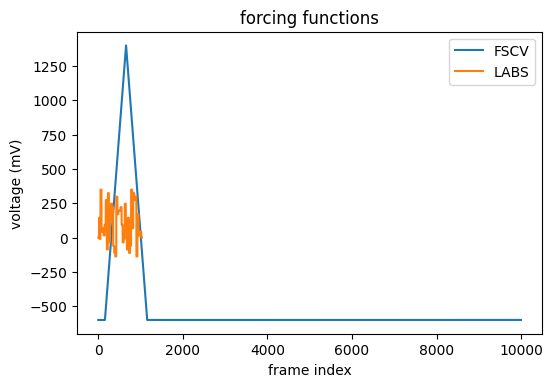

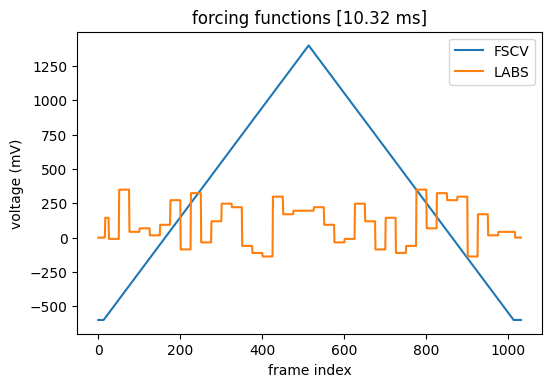

In [1]:
# Import Packages
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import voltammetry
import matplotlib as mpl
from sklearn.metrics import r2_score
from glmnet_python import cvglmnetCoef
import pyabf
FSCVpath = 'FSCV_DA_NE_data/'
LABSpath = 'LABS_DA_NE_data/'
c_analyte = ['#1f77b4','#8B0000']# colors for each analyte
# load data
FSCV_0 = h5py.File('FSCV_DA_NE_data/FSCV_DA_NE_data_0000.h5','r')
LABS_0 = h5py.File('LABS_DA_NE_data/LABS_DA_NE_data_0000.h5','r')
plt.figure(dpi=100)
plt.plot(FSCV_0['CMD'][:,0])
plt.plot(LABS_0['CMD'][:,0])
plt.title('forcing functions')
plt.legend({'FSCV','LABS'})
plt.xlabel('frame index')
plt.ylabel('voltage (mV)')

plt.figure(dpi=100)
plt.plot(FSCV_0['CMD'][144:1176,0])
plt.plot(LABS_0['CMD'][:,0])
plt.title('forcing functions [10.32 ms]')
plt.legend({'FSCV','LABS'})
plt.xlabel('frame index')
plt.ylabel('voltage (mV)');


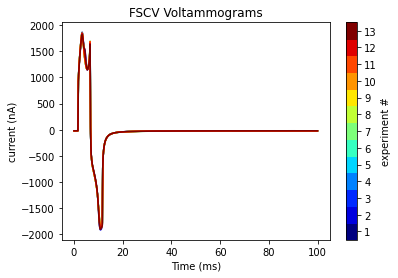

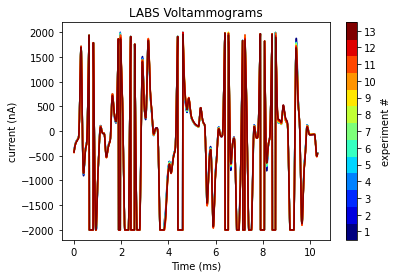

In [2]:
# Load data,Display voltammograms
FSCVvgrams = voltammetry.Data(FSCVpath)
FSCVlabels = voltammetry.Mulabels(FSCVpath,'run.csv')

LABSvgrams = voltammetry.Data(LABSpath)
LABSlabels = voltammetry.Mulabels(LABSpath,'run.csv')

FSCV_plot = FSCVvgrams._plotVoltammograms()
plt.title('FSCV Voltammograms')

LABS_plot = LABSvgrams._plotVoltammograms()
plt.title('LABS Voltammograms');

In [3]:
# Preprocess data
# For the FSCV, data in the equilibration period are also removed.
FSCV_data = voltammetry.PreprocessedData(FSCVvgrams.Voltammogram[160:1160,:,:], FSCVlabels,window_size=425,trainingSampleSize=125)

LABS_data = voltammetry.PreprocessedData(LABSvgrams.Voltammogram[16:1016], LABSlabels,window_size=425,trainingSampleSize=125,corr_over=True)


Start partition
Finding stable section with window size 425
Partitioning data with training sample size 125
Flattening Data
PRE-PROCESSING COMPLETE!!!!
Correcting overflow negative values
Start partition
Finding stable section with window size 425
Partitioning data with training sample size 125
Flattening Data
PRE-PROCESSING COMPLETE!!!!


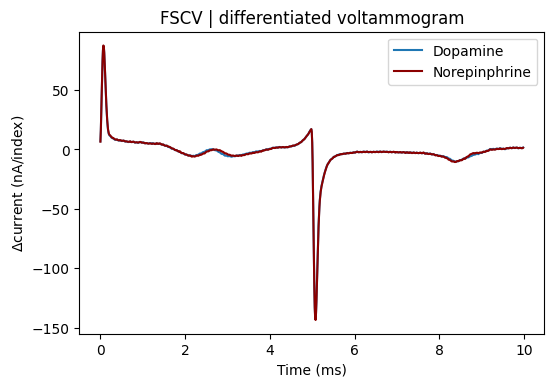

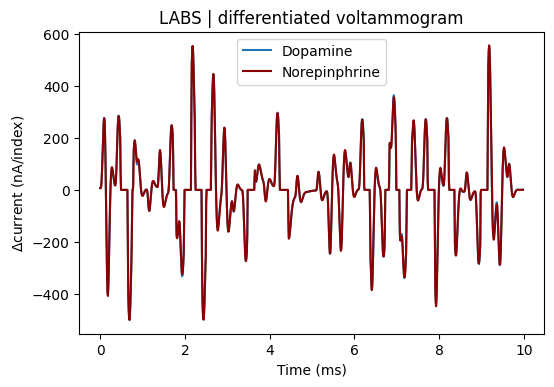

In [4]:
# plot processed vgrams
# As an alternative to background subtraction, the voltammograms are differentiated
# with respect to index.
# The maximum concentrations of dopamine and norepinphrine (3200 nM) are plotted for comparison
# FSCV
idx_DA = np.where(FSCV_data.training.labels[:,0]==3200)[0][0]
idx_NE = np.where(FSCV_data.training.labels[:,1]==3200)[0][0]
y_DA = np.diff(FSCV_data.training.vgrams[idx_DA,:])
y_NE = np.diff(FSCV_data.training.vgrams[idx_NE,:])

x = np.arange(len(y_DA))/100
plt.figure(dpi=100)
plt.plot(x,y_DA,color=c_analyte[0])
plt.plot(x,y_NE,color=c_analyte[1])

plt.title('FSCV | differentiated voltammogram')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$current (nA/index)');
plt.legend({'Dopamine','Norepinphrine'})
# LABS
plt.figure(dpi=100)
idx_DA = np.where(LABS_data.training.labels[:,0]==3200)[0][0]
idx_NE = np.where(LABS_data.training.labels[:,1]==3200)[0][0]
y_DA = np.diff(LABS_data.training.vgrams[idx_DA,:])
y_NE = np.diff(LABS_data.training.vgrams[idx_NE,:])
x = np.arange(len(y_DA))/100
plt.plot(x,y_DA,color=c_analyte[0])
plt.plot(x,y_NE,color=c_analyte[1])
plt.title('LABS | differentiated voltammogram')
plt.xlabel('Time (ms)')
plt.legend({'Dopamine','Norepinphrine'})

plt.ylabel(r'$\Delta$current (nA/index)');

In [5]:
# FSCV EN-penalized regression training, testing
max_core = 8 # maxmum number of corest that can be used in parallel by machine for training

bestAlpha = voltammetry.best_alpha(FSCV_data.training)

FSCV_cvFit = voltammetry.train_analyte(FSCV_data.training, alpha=bestAlpha,parallel=max_core)
FSCV_predictions = voltammetry.test_analyte(FSCV_data.testing, FSCV_cvFit)

[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores


TRAINING COMPLETE 150.421  seconds. 

Best alpha =  1.0  (error =  2711.57 )

TRAINING COMPLETE  38.416  seconds. 



In [6]:
# LABS EN-penalized regression training, testing
max_core = 8 # maxmum number of corest that can be used in parallel by machine for training

bestAlpha = voltammetry.best_alpha(LABS_data.training)

LABS_cvFit = voltammetry.train_analyte(LABS_data.training, alpha=bestAlpha,parallel=max_core)
LABS_predictions = voltammetry.test_analyte(LABS_data.testing, LABS_cvFit)

[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores
[status]	Parallel glmnet cv with 8 cores


TRAINING COMPLETE 186.731  seconds. 

Best alpha =  1.0  (error =  5231.24 )

TRAINING COMPLETE  74.142  seconds. 



In [7]:
# define plottting function for comparing analyte predictions
# takes in labels and predictions
def plot_regr(labels,preds,analyte=['DA','NE']):
    fig,ax = plt.subplots(2,2,dpi=200)
    analyte = ['DA','NE']
    c_analyte = ['#1f77b4','#8B0000']# colors for each analyte
    for i in range(2):
        for j in range(2):
            labColor=c_analyte[j]
            y = np.squeeze(labels[:,i])
            x = preds[:,j]
            ax[i,j].scatter(x,y,marker='.',color=labColor)
            ax[i,j].set_xlabel(''.join(['actual ',analyte[i],' (nM)']))
            ax[i,j].set_ylabel(''.join(['predicted ',analyte[j],' (nM)']))
            # plot regression line
            [m,b] = np.polyfit(x,y,1)
            ax[i,j].plot(np.linspace(0,3200),m*np.linspace(0,3000)+b,'--k')
            # display R^2
            r2 = r2_score(x,y)
            ax[i,j].text(1200,2800,''.join(['R$^2$=''{0:.3f}'.format(r2)]))
        plt.tight_layout()
    return fig

### Chemical selectivity of models
Below are plots of the predictions of dopamine (DA) and norepinphrine (NE) against the known values of each analyte. 

Top left and bottom right plots correpond to matching known-prediction pairs and ideally show strong correlations (R^2 close to 1). 

The plots in the off diagonal on the top right and bottom left correspond to mismatchted knonw-prediction pairs and should ideally show no correlation (R^2 not close 1).

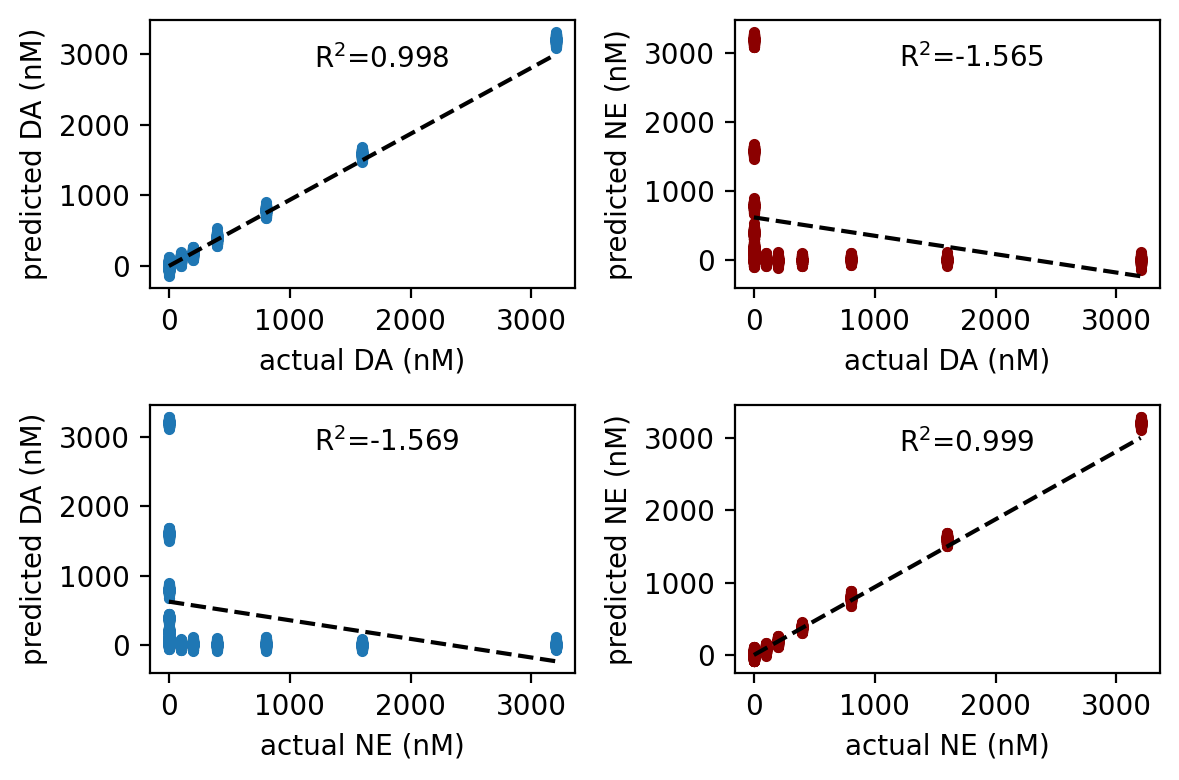

In [8]:
# Plot results for FSCV
preds = FSCV_predictions[:,0:2]
labels = FSCV_data.testing.labels[:,0:2]
fig_FSCV = plot_regr(preds,labels)

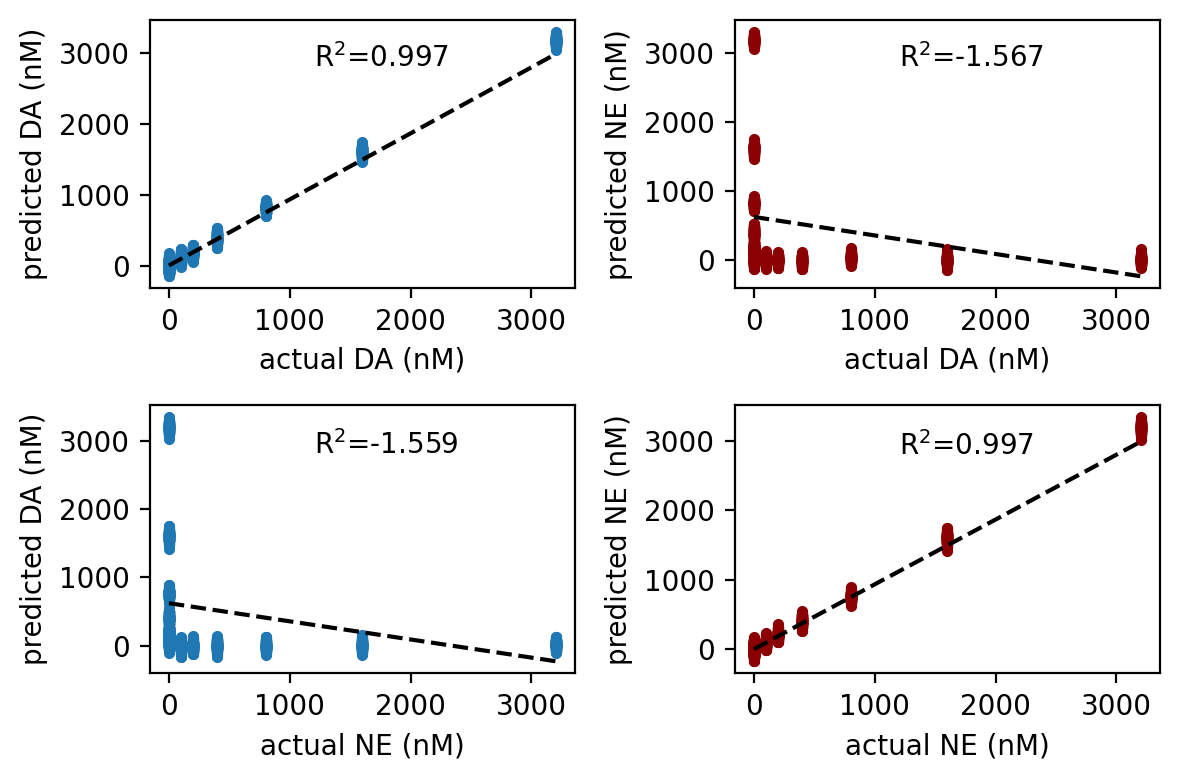

In [9]:
# Plot results for LABS
preds = LABS_predictions[:,0:2]
labels = LABS_data.testing.labels[:,0:2]
fig_LABS = plot_regr(preds,labels)

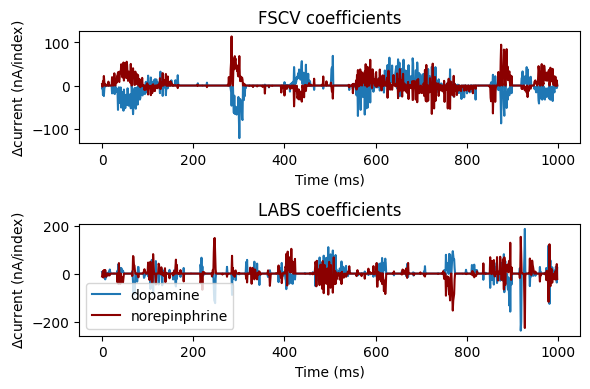

In [10]:
# Plot coefficients
FSCV_betas = cvglmnetCoef(FSCV_cvFit, 'lambda_min')
LABS_betas = cvglmnetCoef(LABS_cvFit, 'lambda_min')
c_analyte = ['#1f77b4','#8B0000']# colors for each analyte
fig,ax = plt.subplots(2,1,dpi=100)

for i in range(2):
    ax[0].plot(np.squeeze(FSCV_betas[i])[1::],color=c_analyte[i])
ax[0].set_title('FSCV coefficients')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel(r'$\Delta$current (nA/index)')
plt.legend({'dopamine','norepinphrine'});
        
for j in range(2):
    ax[1].plot(np.squeeze(LABS_betas[j])[1::],color=c_analyte[j])
ax[1].set_title('LABS coefficients')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel(r'$\Delta$current (nA/index)')
plt.legend({'dopamine','norepinphrine'});

plt.tight_layout()   


In [11]:
## Credits
import sys, platform, time
print('This data demo was created using:')
print('Python Version:',sys.version)
print('Operating System:',platform.system(),'Version',platform.release())
print('GLMnet for python: https://web.stanford.edu/~hastie/glmnet_python/')
print('Numpy: https://numpy.org/')
print('h5py: http://www.h5py.org/')
print('pyplot: https://matplotlib.org/index.html')
print('sklearn: https://scikit-learn.org/stable/')
print('Last updated:',time.strftime('%d-%b-%Y %H:%M:%S',time.localtime()))


This data demo was created using:
Python Version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Operating System: Darwin Version 18.7.0
GLMnet for python: https://web.stanford.edu/~hastie/glmnet_python/
Numpy: https://numpy.org/
h5py: http://www.h5py.org/
pyplot: https://matplotlib.org/index.html
sklearn: https://scikit-learn.org/stable/
Last updated: 20-Dec-2020 21:53:33
